In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import sklearn
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

class RobustLinearRegression(BaseEstimator):
    def __init__(self, estimator='LMS', w0=None):
        """
        estimator: str
            'OLS', 'LAD', 'LMS', 'LTS', 'R', 'REWLSE'
        w0: np.array of shape (d)
            init weights
        """
        
        self.estimator = estimator
        self.w0 = w0
        if w0 is None:
            self.w0 = np.random.rand(X.shape[1] + 1)

        self.w = None
        
    def MSE(self, w, X, y):
        return np.sum((y - (w[0] + X.T * w[1:]))**2)

    def MAE(self, w, X, y):
        return np.sum(abs(y - (w[0] + X.T * w[1:])))

    def LMS(self, w, X, y):
        return np.median((y - (w[0] + X.T * w[1:]))**2)

    def LTS(self, w, X, y):
        return np.sum(np.sort((y - (w[0] + X.T * w[1:]))**2)[:,:int(X.shape[0] / 2 + 1) + 1])

    def R(self, w, X, y):
        r = (y - X.T * w[1:])[0]
        ranks = pd.DataFrame(data={'residues': r}).rank().to_numpy()
        return np.sqrt(12) * np.sum(r * (ranks[:,0] / (X.shape[0] + 1) - 0.5).T)
    
    def REWLSE(self, w, X, y):
        r = (y - (w[0] + X.T * w[1:]))[0]
        sigma = np.median(abs(r - np.median(r)))
        r = 0.675 * r / sigma
        
        absr = np.sort(abs(r))
        temp = [max(sp.stats.norm.cdf(absr[i]) - i / len(absr), 0) for i in range(len(absr)) if absr[i] >= 2.5]
        d = max(temp) if temp else 0
        t = absr[len(absr) - int(np.floor(len(absr) * d)) - 1]
        
        W = np.diag(np.array([1 if abs(ri) < t else 0 for ri in r]))
        X1 = np.hstack((np.ones([X.shape[0], 1], X.dtype), X))
        return np.linalg.inv(X1.T @ W @ X1) @ X1.T @ W @ y
        
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        if self.estimator == 'OLS':
            model = LinearRegression().fit(X, y)
            self.w = np.array([model.intercept_, *model.coef_])
            
        elif self.estimator == 'LAD':
            model = minimize(fun=self.MAE, x0=self.w0, args=(X, y), method='Nelder-Mead')
            if not model.success:
                raise RuntimeError(model.status)
            self.w = model.x
            
        elif self.estimator == 'LMS':
            model = minimize(fun=self.LMS, x0=self.w0, args=(X, y), method='Nelder-Mead')
            if not model.success:
                raise RuntimeError(model.status)
            self.w = model.x
            
        elif self.estimator == 'LTS':
            model = minimize(fun=self.LTS, x0=self.w0, args=(X, y), method='Nelder-Mead')
            if not model.success:
                raise RuntimeError(model.status)
            self.w = model.x
            
        elif self.estimator == 'R':
            model = minimize(fun=self.R, x0=self.w0, args=(X, y), method='Nelder-Mead')
            if not model.success:
                raise RuntimeError(model.status)
            intercept = np.median(Y - X.T * model.x[1:])
            self.w = np.array([intercept, *model.x[1:]])
            
        elif self.estimator == 'REWLSE':
            model = minimize(fun=self.LMS, x0=self.w0, args=(X, y), method='Nelder-Mead')
            if not model.success:
                raise RuntimeError(model.status)
            self.w = self.REWLSE(model.x, X, y)
        
        else:
            raise ValueError('Unknown estimator')
            
        return self
    
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return np.dot(X, self.w)

## 1. Ирисы Фишера

In [3]:
df = sklearn.datasets.load_iris(as_frame=True).frame
X = df['sepal width (cm)'][30:].to_numpy().reshape(-1, 1)
Y = df['sepal length (cm)'][30:].to_numpy()

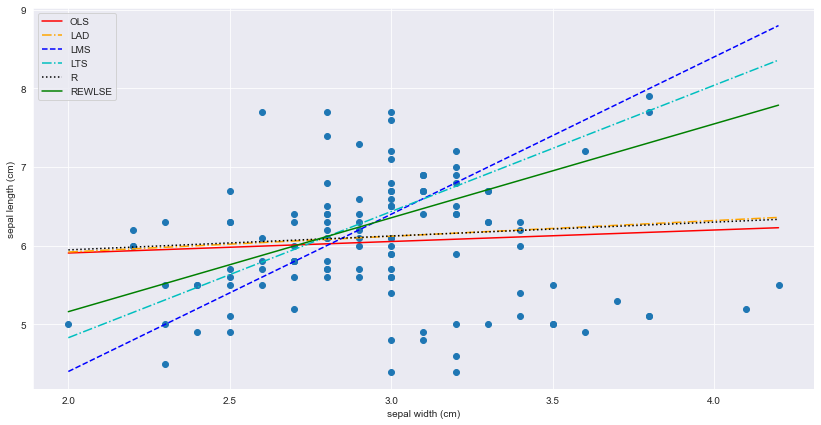

In [4]:
estimators = ['OLS', 'LAD', 'LMS', 'LTS', 'R', 'REWLSE']
colors = ['r', 'orange', 'b', 'c', 'k', 'g']
linestyles = ['-', '-.', '--', '-.', ':', '-']

plt.figure(figsize=(14, 7))

plt.scatter(x=X[:,0], y=Y)

for est, color, style in zip(estimators, colors, linestyles):
    model = RobustLinearRegression(estimator=est).fit(X, Y)
    b = model.w
    
    x = np.linspace(X.min(), X.max(), 10)
    y = [b[0] + b[1] * i for i in x]
    plt.plot(x, y, label=est, color=color, linestyle=style)

plt.xlabel('sepal width (cm)')
plt.ylabel('sepal length (cm)')
plt.legend()
plt.show()

## 2. Потребление сигарет в 1930 и смертность от рака лёгких в 1950

In [5]:
df = pd.DataFrame(data = {
    'country': ['Australia', 'Canada', 'Denmark', 'Finland', 'Great Britain', 'Iceland', 'Netherlands', 'Norway', 'Sweden', 'Switzerland', 'USA'],
    'cigarettes consumption': [480, 500, 380, 1100, 1100, 230, 490, 250, 300, 510, 1300],
    'deaths rates': [180, 150, 170, 350, 460, 60, 240, 90, 110, 250, 200]})

In [6]:
X = df['cigarettes consumption'].to_numpy().reshape(-1, 1)
Y = df['deaths rates'].to_numpy()

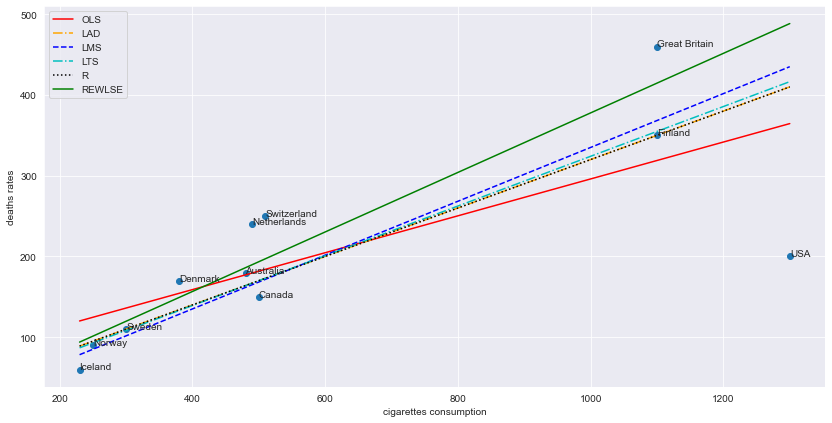

In [7]:
estimators = ['OLS', 'LAD', 'LMS', 'LTS', 'R', 'REWLSE']
colors = ['r', 'orange', 'b', 'c', 'k', 'g']
linestyles = ['-', '-.', '--', '-.', ':', '-']

plt.figure(figsize=(14, 7))

plt.scatter(x=X[:,0], y=Y)
for s, x, y in zip(df['country'], df['cigarettes consumption'], df['deaths rates']):
    plt.text(x = x, y = y, s = s)

for est, color, style in zip(estimators, colors, linestyles):
    model = RobustLinearRegression(estimator=est).fit(X, Y)
    b = model.w
    
    x = np.linspace(X.min(), X.max(), 10)
    y = [b[0] + b[1] * i for i in x]
    plt.plot(x, y, label=est, color=color, linestyle=style)

plt.xlabel('cigarettes consumption')
plt.ylabel('deaths rates')    
plt.legend()
plt.show()

## 3. Уровень ожирения и уровень счастья населения по городам

In [8]:
df = pd.read_csv(r'data/healthy_lifestyle.csv', index_col='rank')
df['obesity levels'] = df['obesity levels'].apply(lambda s: float(s[:-1]))

In [9]:
X = df['obesity levels'].to_numpy().reshape(-1, 1)
Y = df['happiness levels'].to_numpy()

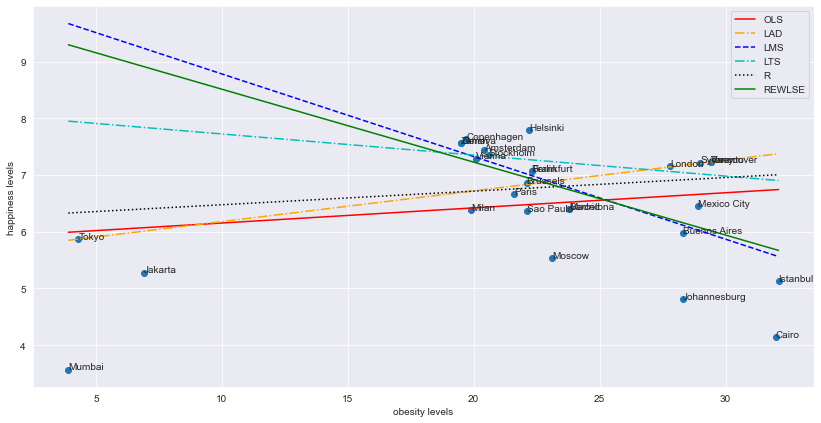

In [10]:
estimators = ['OLS', 'LAD', 'LMS', 'LTS', 'R', 'REWLSE']
colors = ['r', 'orange', 'b', 'c', 'k', 'g']
linestyles = ['-', '-.', '--', '-.', ':', '-']

plt.figure(figsize=(14, 7))

plt.scatter(x=X[:,0], y=Y)
for s, x, y in zip(df['city'], df['obesity levels'], df['happiness levels']):
    plt.text(x = x, y = y, s = s)

for est, color, style in zip(estimators, colors, linestyles):
    model = RobustLinearRegression(estimator=est).fit(X, Y)
    b = model.w
    
    x = np.linspace(X.min(), X.max(), 10)
    y = [b[0] + b[1] * i for i in x]
    plt.plot(x, y, label=est, color=color, linestyle=style)

plt.xlabel('obesity levels')
plt.ylabel('happiness levels')    
plt.legend()
plt.show()

## 4. Продолжительность жизни

In [11]:
df = pd.read_csv(r'data/life_expectancy2002.csv')

In [12]:
X = df['life expectancy'].to_numpy().reshape(-1, 1)
Y = df['adult mortality'].to_numpy()

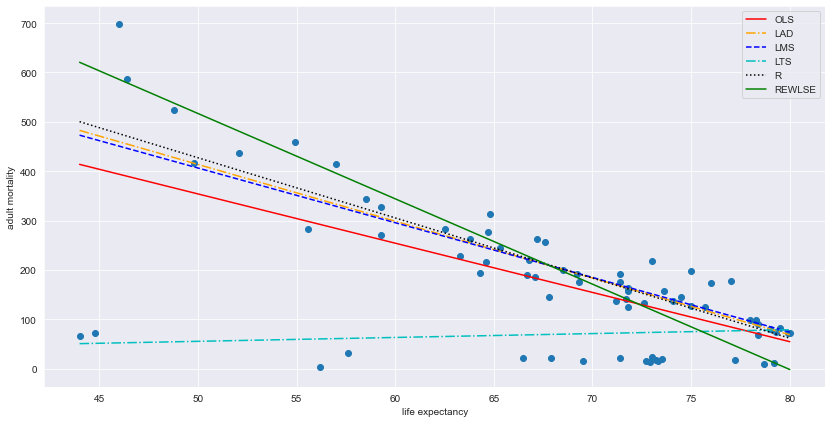

In [13]:
estimators = ['OLS', 'LAD', 'LMS', 'LTS', 'R', 'REWLSE']
colors = ['r', 'orange', 'b', 'c', 'k', 'g']
linestyles = ['-', '-.', '--', '-.', ':', '-']

plt.figure(figsize=(14, 7))

plt.scatter(x=X[:,0], y=Y)

for est, color, style in zip(estimators, colors, linestyles):
    model = RobustLinearRegression(estimator=est).fit(X, Y)
    b = model.w
    
    x = np.linspace(X.min(), X.max(), 10)
    y = [b[0] + b[1] * i for i in x]
    plt.plot(x, y, label=est, color=color, linestyle=style)

plt.xlabel('life expectancy')
plt.ylabel('adult mortality')    
plt.legend()
plt.show()